### Import

In [1]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

# Files
from vehicle import *
from plotting import *
from simulate import *
from mpc import *
from global_path_planning import *
from obstacles import *


### Simulation Input Parameters

In [2]:
#### MPC Properties
dt = 0.5                  # Time step [s]
N = 20                # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 20, 0, 50, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
x_init = [10, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]          # Initial State: [x, y, z, x_dot, y_dot, z_dot]
x_target_last = [10, 48, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]      # Target State: [x, y, z, x_dot, y_dot, z_dot]
T = 40                                 # Simulation time [s]

#### Drone Velocity & Acceleration Constraints
vel_constraints = [-1, 1, -1, 1, -1, 1]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max, z_min, z_max] 
ang_constraints = [-5, 5, -5, 5, -5, 5]         # Angular Velocity Constraints [rad/s]:  [x_min, x_max, y_min, y_max, z_min, z_max]
# vel_ang_constraints = [-5, 5, -5, 5, -5, 5] 

#### Obstacles
static_cost = 300
dynamic_cost = 500

#### Waypoint Radius Threshold
waypoint_radius = 5


In [3]:
#### Obstacle Definition and Initialization

## Define Obstacles
V_obstacles = [[10, 20, 4], [18, 30, 3]]
V_move_obstacles = [[20, 40, -0.1, 0, 6]] #[[20, 40, -0.7, 0, 4], [17, 0, 0, 1, 4], [5, 0, 0, 1, 2]]  # [center_x, center_y, vel_x, vel_y, radius]
H_obstacles = []         # [center_x, center_y, radius]
H_move_obstacles = []  # [center_x, center_y, vel_x, vel_y, radius]

## Initialize Obstacles
obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

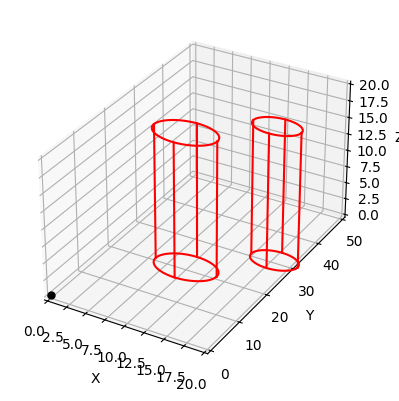

IntProgress(value=0, max=500)

Goal found


In [4]:
# Create Static World
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles, move_obstacles, obstacle_margin=0.5)
World.plot()

# Run RRT* to find a path
path_rrt = rrt_star(World, x_init[:3], x_target_last[:3], radius=15, max_iter=500)


In [5]:
# %%capture
# Setup Controller and Simulate
vehicle = Quadrotor(dt)
controller = lambda x_init, current_wp, last_plan : mpc_control(vehicle, N, x_init, current_wp, pos_constraints, vel_constraints, ang_constraints, last_plan, obstacles, move_obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, x_target_last, N, controller, move_obstacles, path_rrt, waypoint_radius, num_states=12, num_inputs=4)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms ( 21.05us)   4.89ms ( 51.47us)        95
       nlp_g  |  12.00ms (126.32us)  15.56ms (163.82us)        95
  nlp_grad_f  |   9.00ms ( 97.83us)   6.50ms ( 70.65us)        92
  nlp_hess_l  | 127.00ms (  1.41ms) 126.53ms (  1.41ms)        90
   nlp_jac_g  |  39.00ms (423.91us)  46.88ms (509.58us)        92
       total  | 758.00ms (758.00ms) 758.49ms (758.49ms)         1
Optimal cost: 679.6152409035878
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 12.82us)   4.25ms ( 54.53u

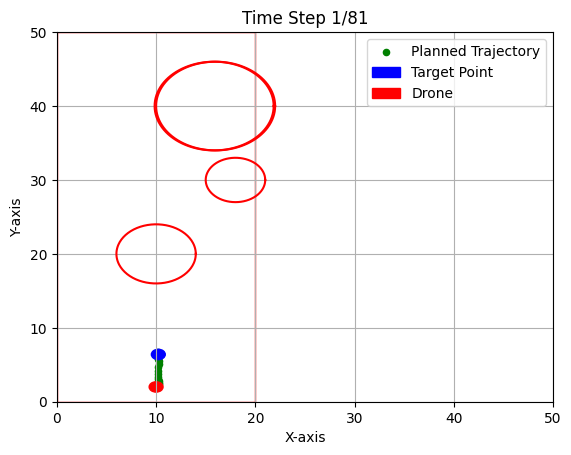

In [6]:
## Plot Simulation
obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

def update(frame):
    # Clear previous frame
    plt.cla()

    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    TargetPoint = plt.Circle((target_state[0][frame], target_state[1][frame]), 0.7, color='b', fill=True, label = "Target Point")
    plt.gca().add_patch(TargetPoint)

    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    MovingObstacleConvert(move_obstacles, dt)

    # Plot Environment
    World.plot2d_ax(plt.gca())

    for move_obstacle in move_obstacles:
        move_obstacle.plot_xy(plt.gca(), 'red')

    # Env Boundaries
    x = pos_constraints[0]
    y = pos_constraints[2]
    width = pos_constraints[1]-x
    height = pos_constraints[3]-x
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rectangle)

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
